## Observations and Insights 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

nums=study_results.groupby(["Timepoint"]).count()
dups= study_results.duplicated(subset=["Mouse ID", "Timepoint"], keep=False)
dups_count=dups.value_counts()
dups_count_df=pd.DataFrame({"Duplicate": dups})
study_results_dups=study_results.merge(dups_count_df,how="outer",left_index=True, right_index=True)
study_results_dups2=study_results_dups.loc[study_results_dups["Duplicate"]!=True]
study_results_dups2=study_results_dups2.drop(columns=["Duplicate"])


# Combine the data into a single dataset

Times=nums.index.tolist()

for x in range(len(Times)):
    if x==0:
        results_combined=study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]].drop(columns=["Timepoint"])
        column_names=list(results_combined.columns)
        del column_names[0]
    elif x==len(Times)-1:
        results_combined=results_combined.merge(study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]], on="Mouse ID", how="outer", suffixes=('_T0',f'_T{x}')).drop(columns=["Timepoint"])
    else:
        results_combined=results_combined.merge(study_results_dups2.loc[study_results_dups2["Timepoint"]==Times[x]], on="Mouse ID", how="outer", suffixes=('',f'_T{x}')).drop(columns=["Timepoint"])


#Combine results DF with mouse DF
data_df=mouse_metadata.merge(results_combined, on="Mouse ID", how="outer",left_index=True, right_index=True)

#Getting rid of mice in metadata that was/were misslabelled in the study results set
data_df=data_df.loc[data_df["Tumor Volume (mm3)_T0"].isnull()==False]

# Display the data table for preview
data_df.head()


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3)_T0,Metastatic Sites_T0,Tumor Volume (mm3)_T1,Metastatic Sites_T1,Tumor Volume (mm3)_T2,...,Tumor Volume (mm3)_T5,Metastatic Sites_T5,Tumor Volume (mm3)_T6,Metastatic Sites_T6,Tumor Volume (mm3)_T7,Metastatic Sites_T7,Tumor Volume (mm3)_T8,Metastatic Sites_T8,Tumor Volume (mm3)_T9,Metastatic Sites_T9
0,k403,Ramicane,Male,21,16,45.0,0.0,45.651331,0.0,43.270852,...,43.262145,1.0,40.605335,1.0,37.967644,1.0,38.379726,2.0,38.982878,2.0
1,s185,Capomulin,Female,3,17,45.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,x401,Capomulin,Female,16,15,45.0,0.0,48.791665,0.0,53.435987,...,64.663626,0.0,69.160520,0.0,71.905117,0.0,NaN,NaN,NaN,NaN
3,m601,Capomulin,Male,22,17,45.0,0.0,47.462891,0.0,49.783419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,g791,Ramicane,Male,11,16,45.0,0.0,45.769249,1.0,46.658395,...,51.828357,1.0,56.098998,1.0,57.729535,1.0,62.175705,1.0,NaN,NaN


## Summary Statistics

In [14]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straighforward, creating multiple series and putting them all together at the end.

Stats=["mean", "median", "variance", "standard deviation", "SEM"]

val=column_names[0]

for x in range(len(Times)):
    lbl=f"{val}_T{x}"
    if x==0:
        data_group_mean=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].mean()})
        data_group_median=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].median()})
        data_group_var=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].var()})
        data_group_std=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].std()})
        data_group_sem=pd.DataFrame({lbl: data_df.groupby(["Drug Regimen"])[lbl].sem()})
    else:
        data_group_mean[lbl]=data_df.groupby(["Drug Regimen"])[lbl].mean()
        data_group_median[lbl]=data_df.groupby(["Drug Regimen"])[lbl].median()
        data_group_var[lbl]=data_df.groupby(["Drug Regimen"])[lbl].var()
        data_group_std[lbl]=data_df.groupby(["Drug Regimen"])[lbl].std()
        data_group_sem[lbl]=data_df.groupby(["Drug Regimen"])[lbl].sem()


data_group_mean.insert(0,"Stat",[Stats[0] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_median.insert(0,"Stat",[Stats[1] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_var.insert(0,"Stat",[Stats[2] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_std.insert(0,"Stat",[Stats[3] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])
data_group_sem.insert(0,"Stat",[Stats[4] for i in range(len(data_df.groupby(["Drug Regimen"])[lbl].mean()))])

data_group=data_group_mean.append(data_group_median).append(data_group_var).append(data_group_std).append(data_group_sem)

data_group.reset_index(drop=False, inplace=True)
data_group=data_group.set_index(["Drug Regimen", "Stat"]).sort_index()

data_group

0.0               0.392311   
             mean                                 45.0              46.678219   
             median                               45.0              46.754269   
             standard deviation                    0.0               1.961557   
             variance                              0.0               3.847707   
Ketapril     SEM                                   0.0               0.377676   
             mean                                 45.0              46.131894   
             median                               45.0              46.493024   
             standard deviation                    0.0               1.730727   
             variance                              0.0               2.995415   
Naftisol     SEM                                   0.0               0.356202   
             mean                                 45.0              46.570970   
             median                               45.0              46.744077   
             standard deviation                    0.0               1.745027   
             variance                              0.0               3.045121   
Placebo      SEM                                   0.0               0.429466   
             mean                                 45.0              46.161373   
             median                               45.0              46.140826   
             standard deviation                    0.0               2.103946   
             variance                              0.0               4.426591   
Propriva     SEM                                   0.0               0.324600   
             mean                                 45.0              46.306628   
             median                               45.0              45.910041   
             standard deviation                    0.0               1.590207   
             variance                              0.0               2.528757   
Ramicane     SEM                                   0.0               0.493977   
             mean                                 45.0              46.625715   
             median                               45.0              46.431216   
             standard deviation                    0.0               2.469886   
             variance                              0.0               6.100335   
Stelasyn     SEM                                   0.0               0.425755   
             mean                                 45.0              46.307957   
             median                               45.0              46.377277   
             standard deviation                    0.0               1.996966   
             variance                              0.0               3.987874   
Zoniferol    SEM                                   0.0               0.476275   
             mean                                 45.0              45.956632   
             median                               45.0              46.684697   
             standard deviation                    0.0               2.333260   
             variance                              0.0               5.444101   

                                 Tumor Volume (mm3)_T2  Tumor Volume (mm3)_T3  \
Drug Regimen Stat                                                               
Capomulin    SEM                              0.326829               0.498236   
             mean                            49.434785              51.459113   
             median                          49.647087              51.211935   
             standard deviation               1.497720               2.228179   
             variance                         2.243164               4.964779   
Ceftamin     SEM                              0.871662               1.073905   
             mean                            46.696205              48.031538   
             median                          47.400683              49.176147   


## Bar and Pie Charts

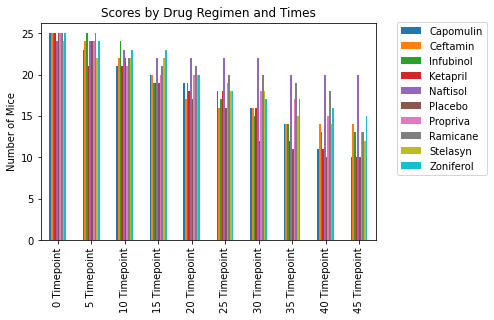

In [91]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 

Groups = data_df.groupby(["Drug Regimen"]).count().index.tolist()

graph_df=pd.DataFrame({"Time0":data_df.groupby(["Drug Regimen"])[f"{val}_T0"].count(),
                       "Time1":data_df.groupby(["Drug Regimen"])[f"{val}_T1"].count(),
                       "Time2":data_df.groupby(["Drug Regimen"])[f"{val}_T2"].count(),
                       "Time3":data_df.groupby(["Drug Regimen"])[f"{val}_T3"].count(),
                       "Time4":data_df.groupby(["Drug Regimen"])[f"{val}_T4"].count(),
                       "Time5":data_df.groupby(["Drug Regimen"])[f"{val}_T5"].count(),
                       "Time6":data_df.groupby(["Drug Regimen"])[f"{val}_T6"].count(),
                       "Time7":data_df.groupby(["Drug Regimen"])[f"{val}_T7"].count(),
                       "Time8":data_df.groupby(["Drug Regimen"])[f"{val}_T8"].count(),
                       "Time9":data_df.groupby(["Drug Regimen"])[f"{val}_T9"].count()})
graph_df=graph_df.transpose()

Times_axis = [str(x)+ " Timepoint" for x in Times]

multiplot = graph_df.plot.bar()
plt.title('Scores by Drug Regimen and Times')
plt.ylabel('Number of Mice')
multiplot.legend(loc='center left',bbox_to_anchor=(1.05, .65))
multiplot = multiplot.set_xticklabels(Times_axis, rotation='vertical')


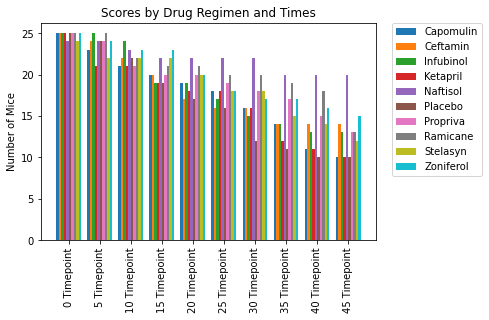

In [73]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

ind=np.arange(len(Groups))
width=.08

fig, ax = plt.subplots()
rects0 = ax.bar(ind - 9*width/2, graph_df[Groups[0]], width, label=Groups[0])
rects1 = ax.bar(ind - 7*width/2, graph_df[Groups[1]], width, label=Groups[1])
rects2 = ax.bar(ind - 5*width/2, graph_df[Groups[2]], width, label=Groups[2])
rects3 = ax.bar(ind - 3*width/2, graph_df[Groups[3]], width, label=Groups[3])
rects4 = ax.bar(ind - width/2, graph_df[Groups[4]], width, label=Groups[4])
rects5 = ax.bar(ind + width/2, graph_df[Groups[5]], width, label=Groups[5])
rects6 = ax.bar(ind + 3*width/2, graph_df[Groups[6]], width, label=Groups[6])
rects7 = ax.bar(ind + 5*width/2, graph_df[Groups[7]], width, label=Groups[7])
rects8 = ax.bar(ind + 7*width/2, graph_df[Groups[8]], width, label=Groups[8])
rects9 = ax.bar(ind + 9*width/2, graph_df[Groups[9]], width, label=Groups[9])



ax.set_ylabel('Number of Mice')
ax.set_title('Scores by Drug Regimen and Times')
ax.set_xticks(ind)
ax.set_xticklabels(Times_axis, rotation='vertical')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [49]:
# Generate a pie plot showing the distribution of female versus male mice using pandas



array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot



## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [16]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [17]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [18]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin


In [19]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen


## Correlation and Regression

In [20]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
